This notebook adresseses an employee scheduling problem involving multiple employees and tasks.

The objective studied is maximizing total number of tasks completed within available times of employees.

Each task can be assigned to at most required number of employees and preemption is not allowed. The duration of tasks is fixed (independent of the assigned employee) and it is assumed that each task can be assigned to any eligible employee (employees are capable to process tasks based on their skillset). Finally, employees are associated with availability start and end times.

As an additional constraint, certain tasks requires **collaborative** work. In other words, those tasks require **multiple employees working simultaneously** to complete the associated task.

The scheduling problem can be also viewed as machine scheduling problem in which employees correspond to machines.

In [1]:
import pandas as pd
import math
import numpy as np
from collections import namedtuple
import warnings
warnings.filterwarnings('ignore')

# READ DATA

In [2]:
employeesTable = pd.read_excel("C:\\Users\\167295724\\Desktop\\EmployeeScheduling\\MasterData.xlsx", sheet_name='Employees', header=0)
employeesTable=employeesTable.head(5) # select only 5 employees in order to have a small-sized problem
employeesTable

,name,availability_start,availability_end,seniority,qualification,pay_rate
0,Anne,480,1020,11,1,25
1,Bethanie,480,1020,4,5,28
2,Betsy,480,1020,2,2,17
3,Cathy,480,1020,2,2,17
4,Cecilia,480,1020,9,5,38


In [3]:
tasksTable = pd.read_excel("C:\\Users\\167295724\\Desktop\\EmployeeScheduling\\MasterData.xlsx", sheet_name='Tasks', header=0)
tasksTable=tasksTable.head(30) # select only 30 tasks in order to have a small-sized problem
tasksTable

,task_id,task_type,task_duration,required_nbr_of_employees
0,T001,Oncology,110,1
1,T002,Cardiac Care,80,1
2,T003,Anaesthesiology,60,1
3,T004,Pediatrics,70,1
4,T005,Oncology,120,1
5,T006,Cardiac Care,80,1
6,T007,Pediatrics,80,1
7,T008,Oncology,60,1
8,T009,Anaesthesiology,110,1
9,T010,Cardiac Care,30,1


In [4]:
skillsTable = pd.read_excel("C:\\Users\\167295724\\Desktop\\EmployeeScheduling\\MasterData.xlsx", sheet_name='Skills', header=0)
skillsTable

,name,department,Eligible?
0,Anne,Anaesthesiology,No
1,Bethanie,Anaesthesiology,Yes
2,Betsy,Anaesthesiology,Yes
3,Cathy,Anaesthesiology,Yes
4,Cecilia,Anaesthesiology,Yes
...,...,...,...
155,Roberta,Geriatrics,No
156,Suzanne,Geriatrics,Yes
157,Vickie,Geriatrics,No
158,Wendie,Geriatrics,Yes


In [5]:
# Create a new dataframe to show compatible employee-task pairs through the Skills Table

# Add a constant column to both DataFrames to perform the cross join
employeesTable['key'] = 1
tasksTable['key'] = 1

# Perform a cross join by merging on the constant column 'key' to list "all" employee-task pairs
cross_joined_df = pd.merge(employeesTable, tasksTable, on='key').drop('key', axis=1)[['name', 'availability_start','availability_end','task_id', 'task_type','task_duration','required_nbr_of_employees']]
employeesTable.drop('key', axis=1, inplace=True)
tasksTable.drop('key', axis=1, inplace=True)
cross_joined_df = cross_joined_df.rename(columns={'task_type': 'department'})
#cross_joined_df

# Create new a table which lists only the tasks that can be processed by corresponding employee among "all" employee-task pairs
employeeTasksTable = pd.merge(cross_joined_df, skillsTable, on=['name', 'department'], how='inner')
employeeTasksTable = employeeTasksTable.sort_values(by=['name', 'task_id'], ascending=[True, True])
employeeTasksTable = employeeTasksTable[employeeTasksTable['Eligible?'] == "Yes"]
employeeTasksTable  

,name,availability_start,availability_end,task_id,department,task_duration,required_nbr_of_employees,Eligible?
0,Anne,480,1020,T001,Oncology,110,1,Yes
9,Anne,480,1020,T002,Cardiac Care,80,1,Yes
1,Anne,480,1020,T005,Oncology,120,1,Yes
10,Anne,480,1020,T006,Cardiac Care,80,1,Yes
2,Anne,480,1020,T008,Oncology,60,1,Yes
...,...,...,...,...,...,...,...,...
126,Cecilia,480,1020,T026,Oncology,60,2,Yes
139,Cecilia,480,1020,T027,Anaesthesiology,110,1,Yes
140,Cecilia,480,1020,T028,Anaesthesiology,110,1,Yes
127,Cecilia,480,1020,T029,Oncology,120,1,Yes


# PREPARE DATA

Tuple data type can be used to retrieve certain values of each row of a dataframe (to be used in the optimization model). Each tuple set can correspond to an input table and the pandas method itertuples() returns a named tuple for each row of a DataFrame.

In [6]:
employeesT  = namedtuple("employeesT",['name', 'availabilityStart', 'availabilityEnd', 'seniority', 'qualification', 'payRate'])
employees  = [employeesT(*employees_row) for employees_row in employeesTable.itertuples(index=False)]
#employees 

In [7]:
tasksT  = namedtuple("tasksT",['taskId', 'taskType', 'taskDuration', 'requiredNbrOfEmployees'])
tasks  = [tasksT(*tasks_row) for tasks_row in tasksTable.itertuples(index=False)]
#tasks 

In [8]:
employeeTasksT  = namedtuple("employeeTasksT",['name', 'availabilityStart', 'availabilityEnd', 'taskId', 'department', 'taskDuration', 'requiredNbrOfEmployees','eligible'])
employeeTasks  = [employeeTasksT(*employeeTasks_row) for employeeTasks_row in employeeTasksTable.itertuples(index=False)]
#employeeTasks

# CREATE A MODEL INSTANCE

In [9]:
from docplex.cp.model import *
mdl = CpoModel(name='employeeScheduling') 

# DEFINE DECISION VARIABLES

In [10]:
# define  processing interval of each task at each "eligible" employee
employeeTasks_itv_vars = {}   
for et in employeeTasks:
    employeeTasks_itv_vars[et] = mdl.interval_var(start=(et.availabilityStart,et.availabilityEnd), end=(et.availabilityStart,et.availabilityEnd*100), size=et.taskDuration, optional=True)

In [11]:
# define sequencing variables for each employee (to be used in no overlap constraint)
sequence_vars = {}  
for e in employees:
    sequence_vars [e] = mdl.sequence_var([employeeTasks_itv_vars[et] for et in employeeTasks if et.name==e.name])

# EXPRESS OBJECTIVE FUNCTION

In [12]:
# maximize number of tasks that are completed by an employee
objective = mdl.sum([mdl.presence_of(employeeTasks_itv_vars[et]) for et in employeeTasks])
mdl.add(mdl.maximize(objective)) 

# DEFINE CONSTRAINTS

In [13]:
# each task can only be assigned to at most number of required employees
for t in tasks:
    mdl.add(mdl.sum(mdl.presence_of(employeeTasks_itv_vars[et]) for et in employeeTasks if et.taskId==t.taskId)<=t.requiredNbrOfEmployees)

In [14]:
# if a task is assigned to an employee and that task requires more than one employee, then ensure that there are required number of employees assigned to that task with overlapping periods
for et1 in employeeTasks:
    if et1.requiredNbrOfEmployees!=1:
        mdl.add(et1.requiredNbrOfEmployees*mdl.presence_of(employeeTasks_itv_vars[et1]) 
                == mdl.sum(mdl.logical_and(mdl.overlap_length(employeeTasks_itv_vars[et1],employeeTasks_itv_vars[et2])==et1.taskDuration,mdl.presence_of(employeeTasks_itv_vars[et2])==1) for et2 in employeeTasks if et1.taskId==et2.taskId))

In [15]:
# no overlap constraint
for e in employees:
    mdl.add(mdl.no_overlap(sequence_vars[e])) 

# SOLVE THE MODEL

In [16]:
msol=mdl.solve(TimeLimit=120, execfile='C:\\Program Files\\IBM\\ILOG\\CPLEX_Studio221\\cpoptimizer\\bin\\x64_win64\\cpoptimizer.exe')
print("Solution: ")
msol.print_solution()

C:/Users/167295724/AppData/Local/Temp/ipykernel_22780/3739665608.py:4(stream:133:34): Warning: Constraint 'overlapLength': interval variable '_ITV_11' is used more than once.
                                                                                                 overlapLength(_ITV_11, _ITV_11)
C:/Users/167295724/AppData/Local/Temp/ipykernel_22780/3739665608.py:4(stream:134:34): Warning: Constraint 'overlapLength': interval variable '_ITV_18' is used more than once.
                                                                                                 overlapLength(_ITV_18, _ITV_18)
C:/Users/167295724/AppData/Local/Temp/ipykernel_22780/3739665608.py:4(stream:135:106): Warning: Constraint 'overlapLength': interval variable '_ITV_34' is used more than once.
                                                                                                  overlapLength(_ITV_34, _ITV_34)
C:/Users/167295724/AppData/Local/Temp/ipykernel_22780/3739665608.py:4(stream:136:105):

# PREPARE OUTPUT TABLES

In [17]:
assignmentReport = [(et.name, et.taskId, et.department
                    ,msol.get_var_solution(employeeTasks_itv_vars[et]).get_start(),msol.get_var_solution(employeeTasks_itv_vars[et]).get_end()) 
                       for et in employeeTasks if msol.get_var_solution(employeeTasks_itv_vars[et]).is_present()]
assignmentReport_df = pd.DataFrame(assignmentReport, columns=['Employee', 'Task', 'Type','StartTime','EndTime'])
assignmentReport_df = assignmentReport_df.sort_values(by=['Employee','StartTime'], ascending=[True, True])
assignmentReport_df 

,Employee,Task,Type,StartTime,EndTime
1,Anne,T002,Cardiac Care,480,560
5,Anne,T025,Cardiac Care,560,670
2,Anne,T005,Oncology,670,790
3,Anne,T008,Oncology,790,850
0,Anne,T001,Oncology,850,960
6,Anne,T026,Oncology,960,1020
4,Anne,T013,Oncology,1020,1130
7,Bethanie,T003,Anaesthesiology,480,540
10,Bethanie,T018,Anaesthesiology,540,630
8,Bethanie,T009,Anaesthesiology,630,740


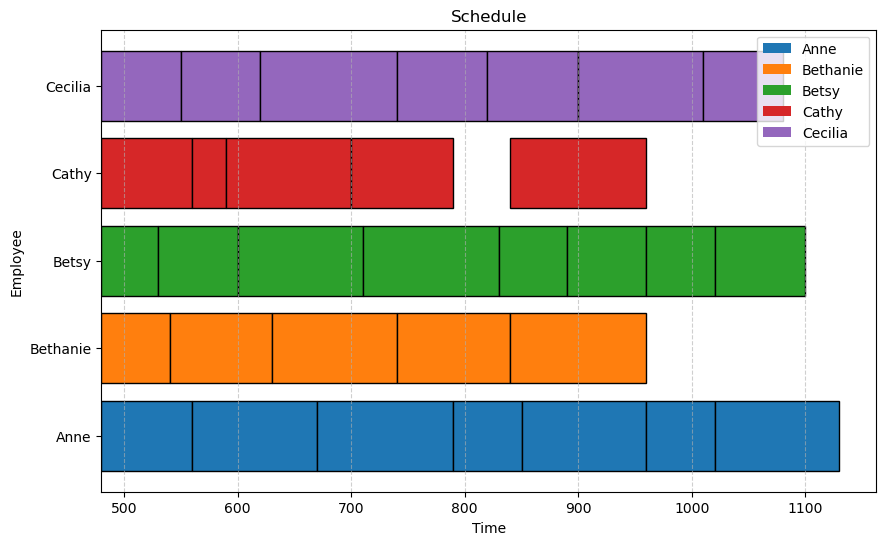

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap

# Your data
df = assignmentReport_df

# Automatically define colors for resources using a colormap
cmap = plt.cm.get_cmap('tab10')  # You can choose other colormaps
colors = [cmap(i) for i in range(len(df['Employee'].unique()))]
resource_colors = dict(zip(df['Employee'].unique(), colors))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the Gantt chart
for i, row in df.iterrows():
    start_time = row['StartTime']
    end_time = row['EndTime']
    task_duration = end_time - start_time
    ax.barh(row['Employee'], task_duration, left=start_time, color=resource_colors[row['Employee']], edgecolor='black', label="EEEE")

# Customize the chart
ax.set_xlabel('Time')
ax.set_ylabel('Employee')
ax.set_title('Schedule')

# Customize legend
legend_labels = [plt.Rectangle((0,0),1,1,fc=resource_colors[resource]) for resource in df['Employee'].unique()]
ax.legend(legend_labels, df['Employee'].unique())

# Add gridlines
ax.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()